# Proyecto Final Machine Learning
Por Sebastián Cancino

## Preparación de entorno de trabajo

### Instalación de librerías
Se instalan las librerías requeridas para la ejecución del notebook

In [1]:
!pip install -U plotly==5.4.0

     |████████████████████████████████| 25.3 MB 1.6 MB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [2]:
!pip install prophet

     |████████████████████████████████| 65 kB 2.9 MB/s 
     |████████████████████████████████| 49 kB 4.7 MB/s 
     |████████████████████████████████| 215 kB 20.1 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6640356 sha256=f1475dd9bca89cd3088561b2b35e743ec25c6999c64bc60167c704a91eb08bac
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


### Importe de librerías
Se definen las librerías a usar en la ejecución del notebook

In [3]:
import pandas as pd
import numpy as np
import missingno as msno
import plotly.express as px
from prophet import Prophet
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

## Carga de datos
Se cargan los datos y se verifica que estén cargados correctamente

In [4]:
url = 'https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=xcl&macro=./RVII/709/Cal/PM25//PM25.horario.horario.ic&from=120707&to=211130&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath='
types = dtype={'FECHA (YYMMDD)': str,
               'HORA (HHMM)': str}
df = pd.read_csv(url, sep=';', dtype=types)

In [5]:
df

,FECHA (YYMMDD),HORA (HHMM),Registros validados,Registros preliminares,Registros no validados,Unnamed: 5
0,120707,0100,NaN,NaN,NaN,NaN
1,120707,0200,NaN,NaN,NaN,NaN
2,120707,0300,NaN,NaN,NaN,NaN
3,120707,0400,NaN,NaN,NaN,NaN
4,120707,0500,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
82410,211130,1900,NaN,3,NaN,NaN
82411,211130,2000,NaN,7,NaN,NaN
82412,211130,2100,NaN,7,NaN,NaN
82413,211130,2200,NaN,11,NaN,NaN


## Preprocesamiento de datos
Se analizan los datos faltantes para imputarlos

### Matriz de datos faltantes

En el gráfico se pueden apreciar los datos faltantes, y cómo la presencia de los registros se relaciona. Si no hay registros validados, usualmente hay preliminares. Y si estos últimos tampoco se encuentran presentes, suele ver no validados disponibles

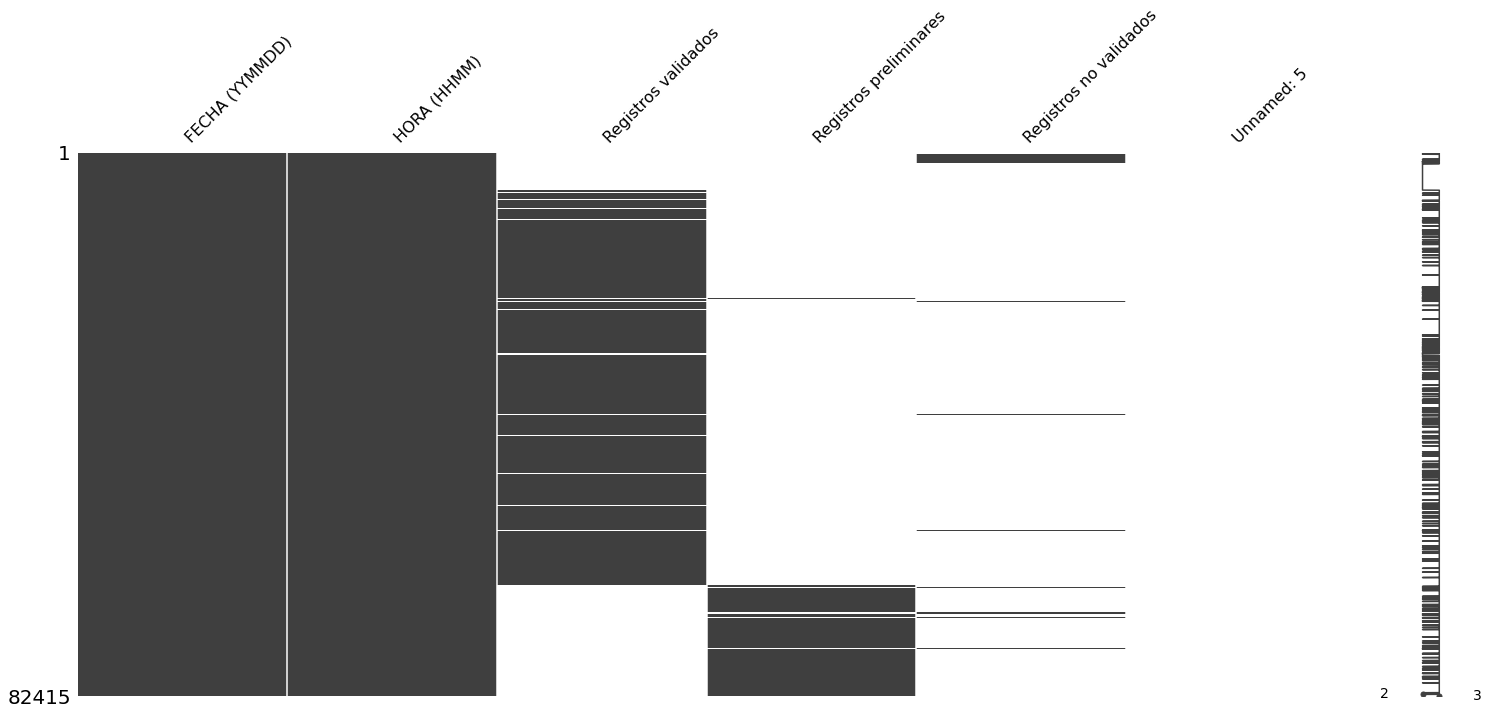

In [6]:
msno.matrix(df)

### Preparación de columnas

Se crea una nueva columna 'Date' con la fecha en formato YYYY-MM-DD HH:MM:SS, y se imputan los datos faltantes. Se decide utilizar los registros validados si están presentes, los preliminares en caso de no haber validados y los no validados si tampoco hay presentes. Estos quedan en la columna 'Registro'

En los casos donde no hay ningún registro, simplemente se eliminará la fila.

In [7]:
df['Date'] = df.apply(lambda x: f'20{x["FECHA (YYMMDD)"][0:2]}-{x["FECHA (YYMMDD)"][2:4]}-{x["FECHA (YYMMDD)"][4:6]} {x["HORA (HHMM)"][0:2]}:{x["HORA (HHMM)"][2:4]}:00', axis=1)
df['Registro'] = df.apply(lambda x: x['Registros validados'] if  not pd.isna(x['Registros validados']) else x['Registros preliminares'] if  not pd.isna(x['Registros preliminares']) else x['Registros no validados'] if not pd.isna(x['Registros no validados']) else np.NaN ,axis=1)

Se obserba el resultado obtenido

In [8]:
df

,FECHA (YYMMDD),HORA (HHMM),Registros validados,Registros preliminares,Registros no validados,Unnamed: 5,Date,Registro
0,120707,0100,NaN,NaN,NaN,NaN,2012-07-07 01:00:00,NaN
1,120707,0200,NaN,NaN,NaN,NaN,2012-07-07 02:00:00,NaN
2,120707,0300,NaN,NaN,NaN,NaN,2012-07-07 03:00:00,NaN
3,120707,0400,NaN,NaN,NaN,NaN,2012-07-07 04:00:00,NaN
4,120707,0500,NaN,NaN,NaN,NaN,2012-07-07 05:00:00,NaN
...,...,...,...,...,...,...,...,...
82410,211130,1900,NaN,3,NaN,NaN,2021-11-30 19:00:00,3
82411,211130,2000,NaN,7,NaN,NaN,2021-11-30 20:00:00,7
82412,211130,2100,NaN,7,NaN,NaN,2021-11-30 21:00:00,7
82413,211130,2200,NaN,11,NaN,NaN,2021-11-30 22:00:00,11


Se observa nuevamente la matriz de datos faltantes, y se puede apreciar de que aún existen registros faltantes, por lo que se eliminará las filas.

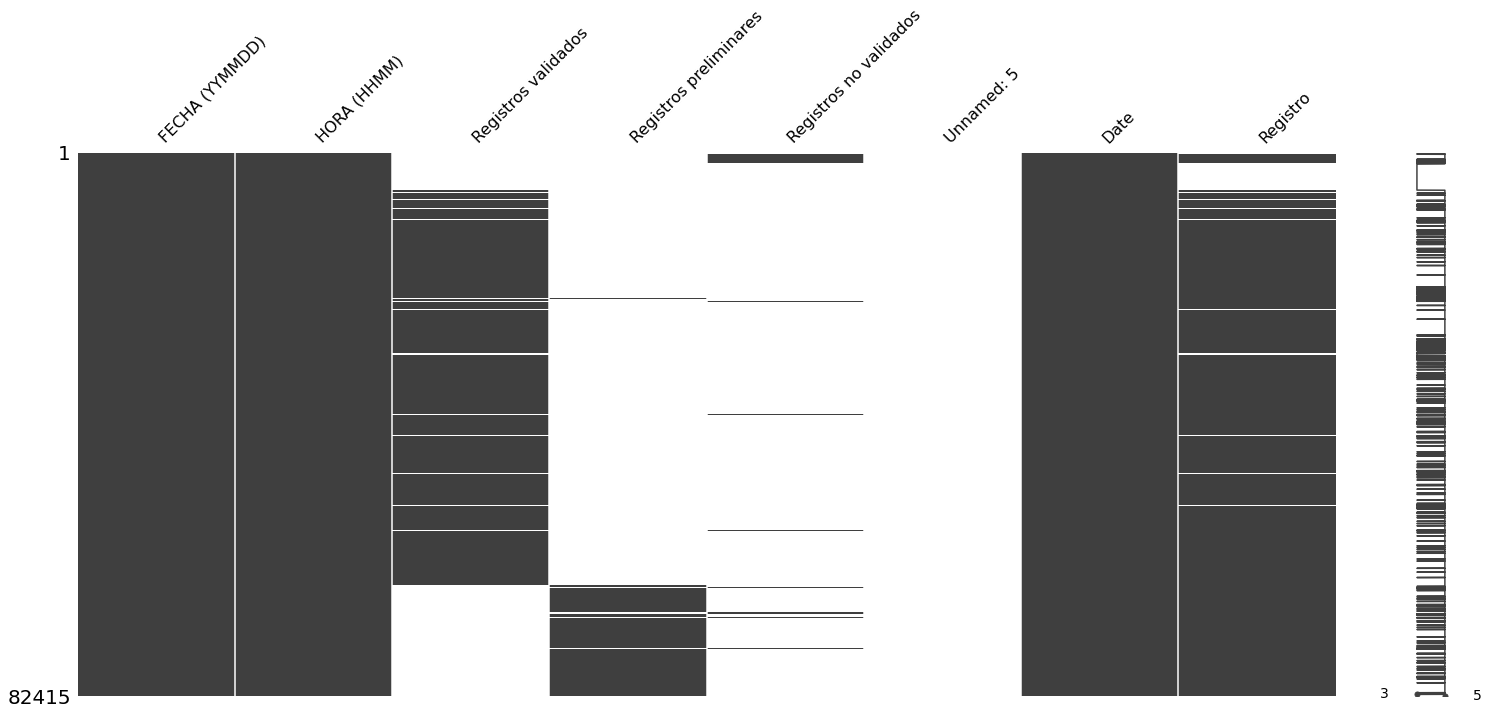

In [9]:
msno.matrix(df)

Se eligen las columnas relevantes al caso ('Date' y 'Registro'), se eliminan las filas con datos faltantes y  se cambia la coma decial por un punto decimal en los registros para que sean correctamente interpretados como valores numericos.

In [10]:
df = df[['Date', 'Registro']]

In [11]:
df = df.dropna()

In [12]:
df['Registro'] = pd.to_numeric(df['Registro'].apply(lambda x: x.replace(',', '.')))
df['Date'] = pd.to_datetime(df['Date'])

Ahora, en la matriz de datos faltantes se puede apreciar de que no hay datos faltantes.

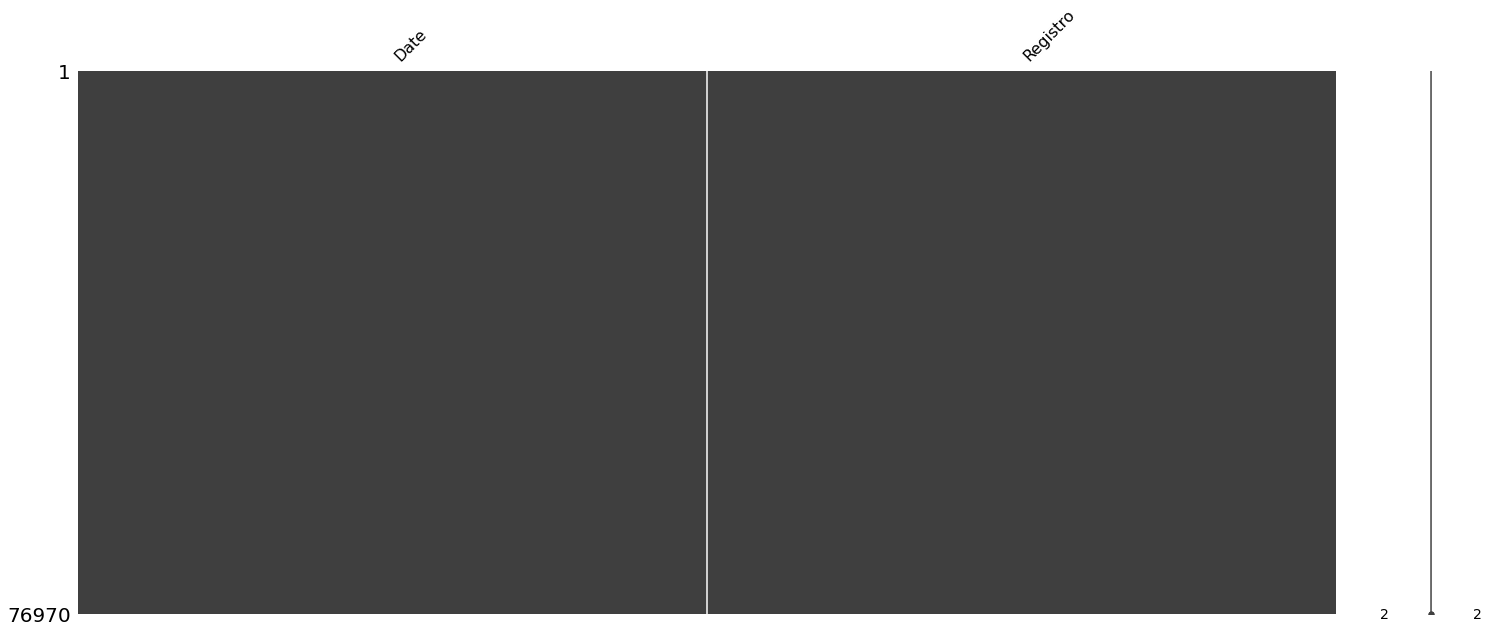

In [13]:
msno.matrix(df)

## Visualización de datos
Se hace una pequeña visualización de los registros de contaminación en el período de 2012 a 2021

Se observan los registros de contaminación en el tiempo. Se puede apreciar que entre los años 2012 a 2014, incluídos, existe una gran cantidad de valores anormales: valores muy altos en comparación al resto, valores negativos y valores faltantes.

Por estos motivos, se decide que en el resto del proyecto sólo se trabajará con los datos del año 2015 en adelante.

In [14]:
fig = px.line(df, x='Date', y='Registro')
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [15]:
df = df[df['Date'] > '2015-01-01']

Se vuelve a visualizar los datos, esta vez spolo los valores posteriores al primero de Enero del 2015. No se aprecia ningún valor fuera de lo normal.

In [16]:
fig = px.line(df, x='Date', y='Registro')
fig.show()

Adicionalmente, en el proyecto también se trabajará con los promedios diarios, por lo que se crea el dataset correspondiente agrupando por día y promediando los valores.

In [17]:
mean_df = df.groupby(by=df['Date'].dt.date).mean().reset_index()
mean_df['Date'] = pd.to_datetime(mean_df['Date'])

Se grafican los valores de contaminación promedio durante el período de estudio.

Se puede apreciar una línea más sencilla, debido a la menor cantidad de datos.

In [18]:
fig = px.line(mean_df, x='Date', y='Registro')
fig.show()

## Modelado 

Se comienza el modelado renombrando las columnas de los datasets de estudio para cumplir con los requisitos del modelo Prophet. La fecha debe llamarse 'ds', y el valor a predecir 'y'.

In [19]:
df = df.rename(columns={'Registro': 'y', 'Date': 'ds'})
mean_df = mean_df.rename(columns={'Registro': 'y', 'Date': 'ds'})

Con la intención de dejar aproximadamente un 70% de datos de entrenamiento y un 30% de datos de prueba, se divide en entrenamiento y prueba los valores registrados antes y después del primer día del 2020, respectivamente.

In [20]:
train_df = df[df['ds'] <= '2019-12-31']
test_df = df[df['ds'] > '2019-12-31'] 

Se obtienen porcentajes lo sufientemente cercanos a lo buscado.

In [21]:
print(f'Dataset de entrenamiento: {train_df.shape[0] / df.shape[0]}')
print(f'Dataset de prueba: {test_df.shape[0] / df.shape[0]}')

Dataset de entrenamiento: 0.720971901269299
Dataset de prueba: 0.27902809873070095


In [22]:
mean_train_df = mean_df[mean_df['ds'] <= '2019-12-31']
mean_test_df = mean_df[mean_df['ds'] > '2019-12-31'] 

In [23]:
print(f'Dataset de entrenamiento: {mean_train_df.shape[0] / mean_df.shape[0]}')
print(f'Dataset de prueba: {mean_test_df.shape[0] / mean_df.shape[0]}')

Dataset de entrenamiento: 0.7215592680986476
Dataset de prueba: 0.27844073190135243


Se crean los modelos a utilizar. Uno para el total de los registros, y el otro para el promedio diario. De ahí el nombre "total" y "mean", respectivamente.

In [24]:
total_model = Prophet()
total_model.fit(train_df)

In [25]:
mean_model =  Prophet()
mean_model.fit(mean_train_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Se crean los datasets para realizar predicciones en cada modelo.

In [26]:
# Son 2 años de 365 días, con 24 horas cada uno.
total_future = total_model.make_future_dataframe(periods= 365 * 2 * 24, freq='H')
total_future.tail()

,ds
60570,2021-12-29 20:00:00
60571,2021-12-29 21:00:00
60572,2021-12-29 22:00:00
60573,2021-12-29 23:00:00
60574,2021-12-30 00:00:00


In [27]:
# Lo mismo de arriba, sólo que aqui no son días
mean_future =  mean_model.make_future_dataframe(periods= 365 * 2)
mean_future.tail()

,ds
2539,2021-12-26
2540,2021-12-27
2541,2021-12-28
2542,2021-12-29
2543,2021-12-30


Se realiza la predicción con cada modelo.

In [28]:
total_forecast = total_model.predict(total_future)
total_forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
60570,2021-12-29 20:00:00,33.313414,-151.081834,198.946389,-140.871270,200.047664,-1.807644,-1.807644,-1.807644,15.205291,15.205291,15.205291,0.007192,0.007192,0.007192,-17.020127,-17.020127,-17.020127,0.0,0.0,0.0,31.505770
60571,2021-12-29 21:00:00,33.313818,-145.021753,204.281053,-140.883559,200.050342,2.182775,2.182775,2.182775,19.206992,19.206992,19.206992,-0.000182,-0.000182,-0.000182,-17.024035,-17.024035,-17.024035,0.0,0.0,0.0,35.496593
60572,2021-12-29 22:00:00,33.314222,-135.940921,205.736382,-140.900025,200.053021,1.963899,1.963899,1.963899,18.995183,18.995183,18.995183,-0.003317,-0.003317,-0.003317,-17.027967,-17.027967,-17.027967,0.0,0.0,0.0,35.278121
60573,2021-12-29 23:00:00,33.314627,-141.559826,204.320552,-140.916490,200.055533,-1.262001,-1.262001,-1.262001,15.772403,15.772403,15.772403,-0.002482,-0.002482,-0.002482,-17.031922,-17.031922,-17.031922,0.0,0.0,0.0,32.052625
60574,2021-12-30 00:00:00,33.315031,-150.770570,203.374169,-140.932956,200.057530,-5.649321,-5.649321,-5.649321,11.384559,11.384559,11.384559,0.002020,0.002020,0.002020,-17.035900,-17.035900,-17.035900,0.0,0.0,0.0,27.665710


In [29]:
mean_forecast = mean_model.predict(mean_future)
mean_forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2539,2021-12-26,25.922597,-12.897183,28.408122,24.431215,27.144798,-18.476594,-18.476594,-18.476594,-2.075928,-2.075928,-2.075928,-16.400666,-16.400666,-16.400666,0.0,0.0,0.0,7.446003
2540,2021-12-27,25.924221,-13.782635,27.342709,24.430492,27.151195,-18.245771,-18.245771,-18.245771,-1.876652,-1.876652,-1.876652,-16.369119,-16.369119,-16.369119,0.0,0.0,0.0,7.678450
2541,2021-12-28,25.925846,-10.108047,29.778742,24.429768,27.158008,-15.574458,-15.574458,-15.574458,0.786176,0.786176,0.786176,-16.360634,-16.360634,-16.360634,0.0,0.0,0.0,10.351388
2542,2021-12-29,25.927471,-8.582973,30.534739,24.429045,27.162487,-15.966756,-15.966756,-15.966756,0.406421,0.406421,0.406421,-16.373176,-16.373176,-16.373176,0.0,0.0,0.0,9.960715
2543,2021-12-30,25.929095,-9.246584,29.755898,24.428321,27.166967,-16.320570,-16.320570,-16.320570,0.083019,0.083019,0.083019,-16.403590,-16.403590,-16.403590,0.0,0.0,0.0,9.608525


Se grafican los datos obtenidos, primero en total, luego por componentes, en cada dataset.

### Visualización de predicción de registros horarios

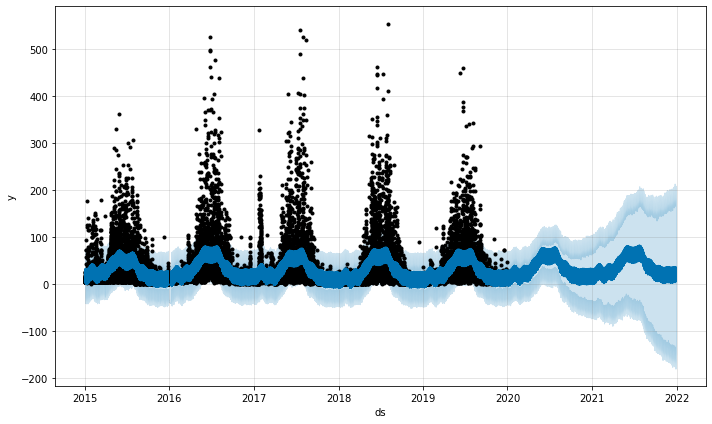

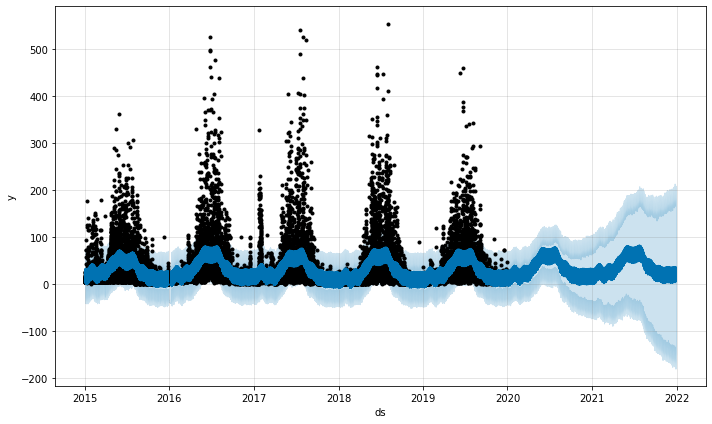

In [30]:
total_model.plot(total_forecast)

### Visualización de predicción de componentes de registro horario

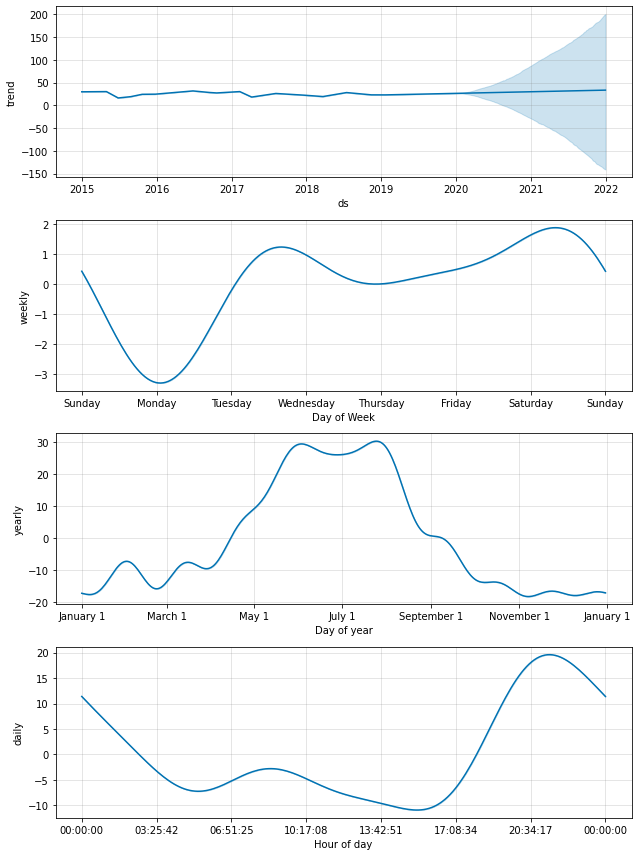

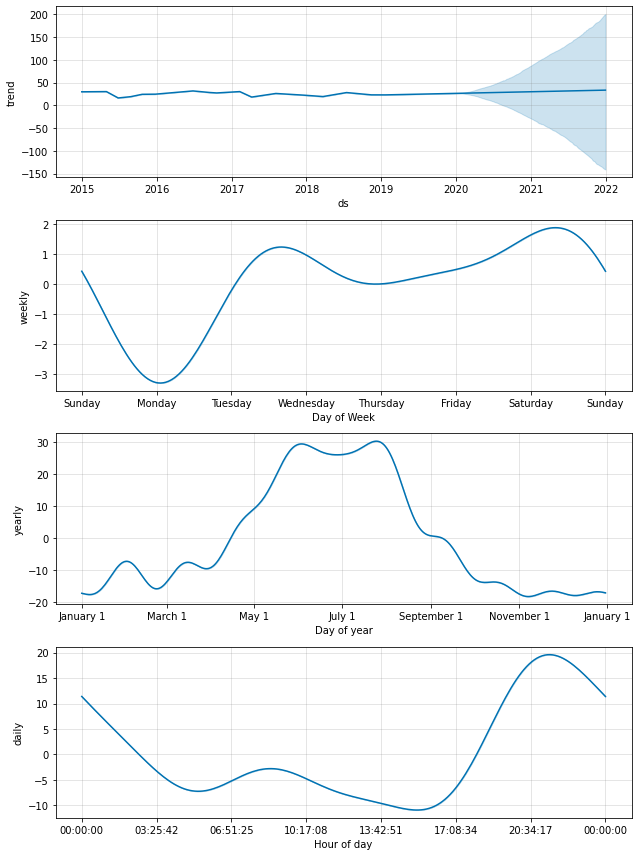

In [31]:
total_model.plot_components(total_forecast)

### Visualizacón de predicción de registros diarios

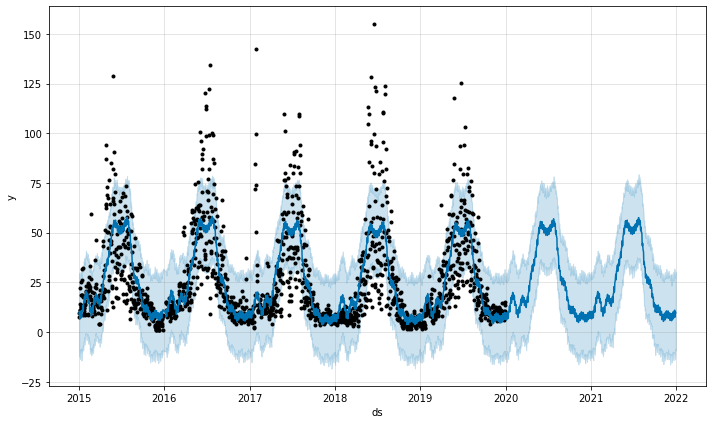

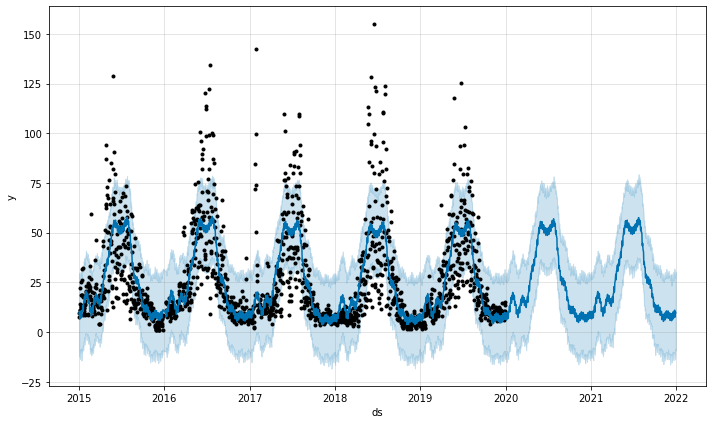

In [32]:
mean_model.plot(mean_forecast)

### Visualización de predicción de componentes de registro diario

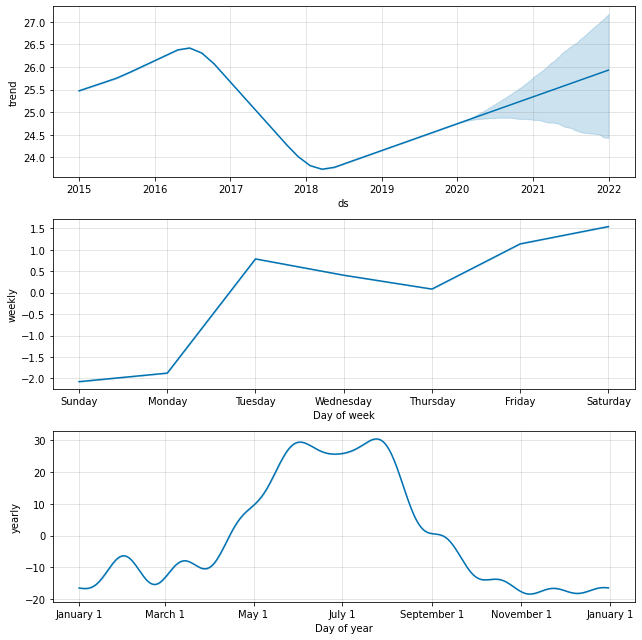

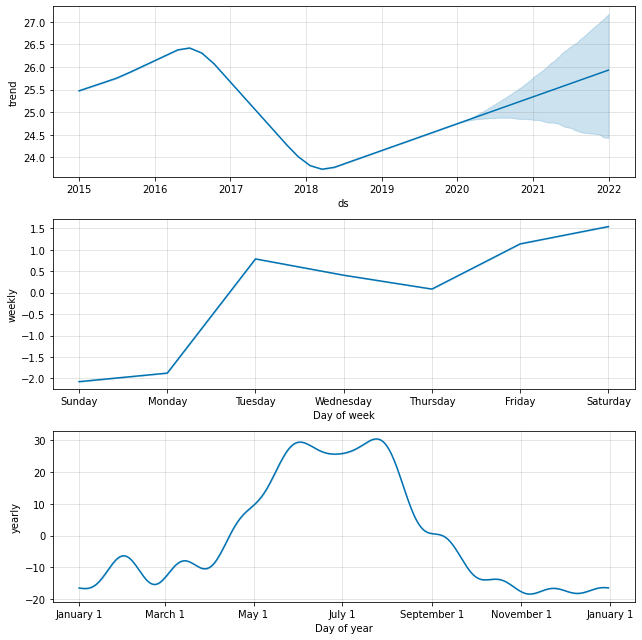

In [33]:
mean_model.plot_components(mean_forecast)

## Comprobación de resultados obtenidos

Se seleccionan los valores presentes en el set de prueba y en el set de predicción de cada dataset.

In [34]:
sel_total_forecast = total_forecast[total_forecast.set_index('ds').index.isin(test_df.set_index('ds').index)][['ds', 'yhat']]
sel_mean_forecast = mean_forecast[mean_forecast.set_index('ds').index.isin(mean_test_df.set_index('ds').index)][['ds', 'yhat']]

Se comprueba la correcta selección de datos, revisando cabezas y colas.

In [35]:
sel_total_forecast.head()

,ds,yhat
43055,2019-12-31 01:00:00,16.062168
43056,2019-12-31 02:00:00,11.913725
43057,2019-12-31 03:00:00,7.821469
43058,2019-12-31 04:00:00,4.355359
43059,2019-12-31 05:00:00,2.566920


In [36]:
test_df.head()

,ds,y
65592,2019-12-31 01:00:00,8.0
65593,2019-12-31 02:00:00,9.0
65594,2019-12-31 03:00:00,7.0
65595,2019-12-31 04:00:00,11.0
65596,2019-12-31 05:00:00,14.0


In [37]:
sel_total_forecast.tail()

,ds,yhat
59873,2021-11-30 19:00:00,24.755252
59874,2021-11-30 20:00:00,32.224951
59875,2021-11-30 21:00:00,36.182647
59876,2021-11-30 22:00:00,35.920417
59877,2021-11-30 23:00:00,32.641670


In [38]:
test_df.tail()

,ds,y
82410,2021-11-30 19:00:00,3.0
82411,2021-11-30 20:00:00,7.0
82412,2021-11-30 21:00:00,7.0
82413,2021-11-30 22:00:00,11.0
82414,2021-11-30 23:00:00,7.0


In [39]:
sel_mean_forecast.head()

,ds,yhat
1814,2020-01-01,8.678024
1815,2020-01-02,8.301679
1816,2020-01-03,9.302995
1817,2020-01-04,9.662487
1818,2020-01-05,6.016551


In [40]:
mean_test_df.head()

,ds,y
1814,2020-01-01,13.666667
1815,2020-01-02,12.333333
1816,2020-01-03,12.583333
1817,2020-01-04,10.416667
1818,2020-01-05,17.500000


In [41]:
sel_mean_forecast.tail()

,ds,yhat
2509,2021-11-26,10.297973
2510,2021-11-27,10.613267
2511,2021-11-28,6.886170
2512,2021-11-29,6.956968
2513,2021-11-30,9.478372


In [42]:
mean_test_df.tail()

,ds,y
2509,2021-11-26,8.750000
2510,2021-11-27,7.000000
2511,2021-11-28,8.333333
2512,2021-11-29,7.875000
2513,2021-11-30,6.375000


### Análisis de resultados obtenidos en dataset con registros horarios

In [43]:
print('Resultados obtenidos en la predicción de los últimos dos años, por hora: ')
print(f'R2  : {r2_score(test_df["y"], sel_total_forecast["yhat"])}')
print(f'MSE : {mean_squared_error(test_df["y"], sel_total_forecast["yhat"])}')
print(f'MAE : {mean_absolute_error(test_df["y"], sel_total_forecast["yhat"])}')
print(f'MAPE: {mean_absolute_percentage_error(test_df["y"], sel_total_forecast["yhat"])}')

Resultados obtenidos en la predicción de los últimos dos años, por hora: 
R2  : 0.27255272985612466
MSE : 900.8791561208831
MAE : 18.27371290519836
MAPE: 1.4894884543200642


### Análisis de resultados obtenidos en dataset con registros diarios

In [44]:
print('Resultados obtenidos en la predicción de los últimos dos años, por promedio diario: ')
print(f'R2  : {r2_score(mean_test_df["y"], sel_mean_forecast["yhat"])}')
print(f'MSE : {mean_squared_error(mean_test_df["y"], sel_mean_forecast["yhat"])}')
print(f'MAE : {mean_absolute_error(mean_test_df["y"], sel_mean_forecast["yhat"])}')
print(f'MAPE: {mean_absolute_percentage_error(mean_test_df["y"], sel_mean_forecast["yhat"])}')

Resultados obtenidos en la predicción de los últimos dos años, por promedio diario: 
R2  : 0.529126276994796
MSE : 253.53137708507566
MAE : 10.153295987267773
MAPE: 0.5817724596138337


## Conclusión

En los resultados obtenidos, se puede apreciar que los resultados obtenidos en ambas predicciones no son lo suficientemente acertados para considerarlos correctos, pero tampoco son predicciones inútiles. 

Esto significa que posiblemente se necesite una mayor optimización en los hiperparámetros del modelo, o filtrado de datos, o validación de los modelos.

Adicionalmente, es interesante destacar cómo los resultados mejoran considerablemente si se realiza un análisis diario en vez de horario. Esto puede ser a que los registros diarios permiten dejar más claramente en evidencia cómo los niveles de contaminación varían a lo largo del año.

In [45]:
!git config --global user.email "you@example.com"
!git config --global user.name "Your Name"


/content/drive/MyDrive/Github/calidad-aire-curico
